# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [23]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [39]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 形状：(num_examples, num_features)，例如 (10, 1)
    y = torch.matmul(X, w) + b # torch.matmul: 矩阵乘法 Xw
    y += torch.normal(0, 0.01, y.shape) # 噪声服从 N(0,0.01^2)
    # 转换为列向量，形状(num_examples, 1) 符合监督学习的标准格式：X(样本×特征), y(样本×1)
    # y 原本是形状 (10,) 的1维张量
    # 机器学习中标签通常是列向量 (10, 1)
    # -1 表示"自动推断该维度大小"，这里等价于 10
    return X, y.reshape((-1, 1)) 

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
y.shape

torch.Size([10, 1])

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [25]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.0747, -0.9202]) 
label: tensor([5.1613])


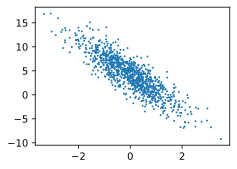

In [41]:
d2l.set_figsize()
# .detach()切断梯度追踪
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [42]:
def data_iter(batch_size, features, labels):
    # 1. 获取样本总数
    num_examples = len(features) # features的第一维大小
    # 2. 创建索引并打乱顺序
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机打乱顺序
    # 3. 按 batch_size 步长遍历
    for i in range(0, num_examples, batch_size):
        # 4. 提取当前批次的索引（防止越界）
        batch_indices = torch.tensor(
            # 如 i=0, batch_size=10 → 取 indices[0:10]
            indices[i: min(i + batch_size, num_examples)])
        # 5. 生成当前批次数据
        # # 返回: (当前批次特征, 当前批次标签);yield 关键字使函数变成生成器
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
# 遍历生成器，每次获取一个批次
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-8.9260e-01, -3.3260e-01],
        [-5.7532e-01,  9.5037e-01],
        [-1.4223e+00,  8.2258e-02],
        [ 2.5445e-01,  3.2994e-01],
        [-4.7240e-01,  3.1183e-01],
        [-8.6977e-01, -1.3729e+00],
        [ 5.5746e-01, -9.2329e-01],
        [-5.4066e-01, -8.1962e-02],
        [-4.1018e-01, -9.7396e-01],
        [-2.3510e+00,  1.2792e-03]]) 
 tensor([[ 3.5543],
        [-0.1807],
        [ 1.0730],
        [ 3.5810],
        [ 2.1820],
        [ 7.1435],
        [ 8.4484],
        [ 3.3977],
        [ 6.6920],
        [-0.5143]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [28]:
# 2个输入特征，1个输出（列向量）
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# 形状:标量偏置（形状为 (1,) 或 ()）
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [29]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数，$\frac{\mathrm{d} }{\mathrm{d} y}\frac{{1} }{2}(\hat{x}-y )^{2}=\hat{y}-y$

In [30]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # shape (2,1) - (2,1) → (2,1)

定义优化算法，SGD 参数更新规则：$\theta=\theta-\eta \cdot \frac{1}{B}\sum_{i=1}^{B}\bigtriangledown_{\theta }L_{i}$

In [31]:
"""
θ(param): 模型参数（如权重 w, 偏置 b）
η(lr): 学习率（步长）
B(batch_size): 批次大小
∇θ​Li: 第i个样本的梯度
"""
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    # 1. 禁用梯度追踪，原因：参数更新是手动的，不属于前向/反向传播
    with torch.no_grad():
        # 2. 遍历所有参数（w, b, ...），params通常是[w,b]或model.parameters()，每个参数都需要独立更新
        for param in params:
            # 3. 参数更新，除以 batch_size 得到平均梯度，保证更新步长与批量大小无关
            param -= lr * param.grad / batch_size
            # 4. 梯度清零，忘记清零的后果：梯度每轮递增，模型发散
            param.grad.zero_()

训练过程

In [32]:
lr = 0.03 # 学习率：步长大小
num_epochs = 3 # 训练轮数：完整遍历数据集3次
net = linreg # 模型函数：线性回归 net(X, w, b)
loss = squared_loss # 损失函数：均方误差

for epoch in range(num_epochs):
    # 随机性：data_iter 会打乱顺序，每轮epoch的批次顺序不同
    for X, y in data_iter(batch_size, features, labels):
        """
        1. 前向传播：计算预测
        net(X, w, b)：线性模型预测y_hat=X@w+b
        loss()：计算平方误差l=0.5*(y_hat-y)²
        """
        l = loss(net(X, w, b), y)
        # 2. 反向传播：计算梯度；.sum()：将批次内所有样本损失求和，得到标量
        # sgd 函数内部会再除以 batch_size 求平均；等价于：loss.mean().backward()（若sgd中不除batch_size）
        l.sum().backward()
        # 3. 参数更新：梯度下降
        sgd([w, b], lr, batch_size)
    # 梯度清零
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        # 5. 打印平均损失，train_l.mean()：计算所有样本的平均损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031949
epoch 2, loss 0.000116
epoch 3, loss 0.000050


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [33]:
"""
w 的形状: (2, 1) - 列向量
true_w 的形状: (2,) - 行向量
直接相减会广播错误（shape mismatch）
true_w - w → 错误！
reshape后形状一致，逐元素相减
"""
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
# 两者都是标量（或形状 (1,)），可直接相减
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


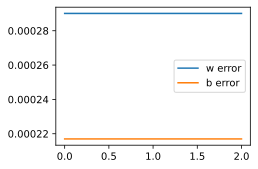

In [43]:
import matplotlib.pyplot as plt
"""
"计算真实参数与训练参数的差值，reshape对齐形状，误差越小说明模型学得越准，是验证算法正确性的金标准。"
"""
# 绘制参数收敛曲线
errors_w = []
errors_b = []

for epoch in range(num_epochs):
    # ... 训练代码 ...
    with torch.no_grad():
        w_error = (true_w - w.reshape(true_w.shape)).norm().item()
        b_error = (true_b - b).abs().item()
        errors_w.append(w_error)
        errors_b.append(b_error)

plt.plot(errors_w, label='w error')
plt.plot(errors_b, label='b error')
plt.legend()
plt.show()